In [1]:
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import findspark
import pyspark

In [3]:
from pyspark.sql.functions import *
import pyspark.sql.functions as f

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, explode
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, ArrayType

In [5]:
# Initialize Spark session
spark = SparkSession.builder.appName("KafkaBatchConsumer").getOrCreate()


24/09/25 21:41:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:

# Define the schema for a single row (one row in the batch)
row_schema = StructType([
    StructField("RowNumber", StringType(), True),
    StructField("CustomerId", StringType(), True),
    StructField("Surname", StringType(), True),
    StructField("CreditScore", StringType(), True),
    StructField("Geography", StringType(), True),
    StructField("Gender", StringType(), True),
    StructField("Age", StringType(), True),
    StructField("Tenure", StringType(), True),
    StructField("Balance", StringType(), True),
    StructField("NumOfProducts", StringType(), True),
    StructField("HasCrCard", StringType(), True),
    StructField("IsActiveMember", StringType(), True),
    StructField("EstimatedSalary", StringType(), True),
    StructField("Exited", StringType(), True)
])

In [7]:
# The entire batch is an array of rows
batch_schema = ArrayType(row_schema)

In [8]:
# Read data from Kafka topic
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "streamig-bank-data") \
    .option("startingOffsets", "earliest")\
    .load()

In [9]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [12]:
# Kafka sends data in key-value format, so we convert it to string
df_kafka = df.selectExpr("CAST(value AS STRING)")

In [13]:
# Parse the JSON data (assuming each message is a batch of 1000 rows)
df_parsed = df_kafka \
    .select(from_json(col("value"), batch_schema).alias("data")) \
    .select(explode(col("data")).alias("row"))  # Explode the array of rows

In [14]:
df_parsed.printSchema()

root
 |-- row: struct (nullable = true)
 |    |-- RowNumber: string (nullable = true)
 |    |-- CustomerId: string (nullable = true)
 |    |-- Surname: string (nullable = true)
 |    |-- CreditScore: string (nullable = true)
 |    |-- Geography: string (nullable = true)
 |    |-- Gender: string (nullable = true)
 |    |-- Age: string (nullable = true)
 |    |-- Tenure: string (nullable = true)
 |    |-- Balance: string (nullable = true)
 |    |-- NumOfProducts: string (nullable = true)
 |    |-- HasCrCard: string (nullable = true)
 |    |-- IsActiveMember: string (nullable = true)
 |    |-- EstimatedSalary: string (nullable = true)
 |    |-- Exited: string (nullable = true)



In [15]:

# Cast columns to appropriate types
df_casted = df_parsed.select(
    col("row.RowNumber").cast(IntegerType()),
    col("row.CustomerId").cast(IntegerType()),
    col("row.Surname"),
    col("row.CreditScore").cast(IntegerType()),
    col("row.Geography"),
    col("row.Gender"),
    col("row.Age").cast(IntegerType()),
    col("row.Tenure").cast(IntegerType()),
    col("row.Balance").cast(DoubleType()),
    col("row.NumOfProducts").cast(IntegerType()),
    col("row.HasCrCard").cast(IntegerType()),
    col("row.IsActiveMember").cast(IntegerType()),
    col("row.EstimatedSalary").cast(DoubleType()),
    col("row.Exited").cast(IntegerType())
)

In [ ]:
# Start the query
query = df_casted \
            .writeStream \
            .format("csv") \
            .option("path", "/home/wick/final_project/bank_data/") \
            .option("checkpointLocation", "/home/wick/final_project/chkpnt/") \
            .outputMode("append") \
            .start()

import time

start_time = time.time()

while query.isActive:
    # Check if 30 minutes have passed
    if time.time() - start_time > 1800:
        query.stop()  # Stop after 30 minutes
    time.sleep(10)  # Check every 10 seconds


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Create a Spark session
spark = SparkSession.builder.appName("Read CSV files").getOrCreate()


24/09/25 18:38:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
# Define the schema
schema = StructType([
    StructField("RowNumber", IntegerType(), True),
    StructField("CustomerId", IntegerType(), True),
    StructField("Surname", StringType(), True),
    StructField("CreditScore", IntegerType(), True),
    StructField("Geography", StringType(), True),
    StructField("Gender", StringType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Tenure", IntegerType(), True),
    StructField("Balance", DoubleType(), True),
    StructField("NumOfProducts", IntegerType(), True),
    StructField("HasCrCard", IntegerType(), True),
    StructField("IsActiveMember", IntegerType(), True),
    StructField("EstimatedSalary", DoubleType(), True),
    StructField("Exited", IntegerType(), True)
])


In [8]:
# Read CSV files without header
df0 = spark.read.csv("file:///home/wick/fina_project/bank_data/*.csv", header=False, schema=schema)

In [9]:

# Show the DataFrame
df0.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [10]:
# Show the DataFrame
df0.show()

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602| Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|     Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|     Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|     Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93

In [11]:
# Count the number of rows in the DataFrame
df0.count()


18000

In [12]:
df1 = df0.dropDuplicates()

# Optionally, show the deduplicated DataFrame
df1.count()

10000

In [13]:
df1.select([count(when(isnull(c), c)).alias(c) for c in df1.columns]).show()

+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



In [14]:
df2 = df1.withColumn('IS_Male',when(col('Gender') == 'Male', 1)).fillna({'IS_Male': 0})
df3 = df2.withColumn('IS_Female',when(col('Gender') == 'Female', 1)).fillna({'IS_Female': 0})
df3.show(10)

+---------+----------+----------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------+---------+
|RowNumber|CustomerId|         Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|IS_Male|IS_Female|
+---------+----------+----------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------+---------+
|      130|  15591607|          Fernie|        770|   France|  Male| 24|     9|101827.07|            1|        1|             0|      167256.35|     0|      1|        0|
|      360|  15592386|        Campbell|        520|   France|  Male| 58|     3|      0.0|            2|        0|             1|       32790.02|     0|      1|        0|
|      721|  15721658|         Fleming|        672|    Spain|Female| 56|     2|209767.31|            2|        1|             1|      150694.42|     1

In [15]:
df3.groupBy("geography").count().show()

+---------+-----+
|geography|count|
+---------+-----+
|  Germany| 2509|
|   France| 5014|
|    Spain| 2477|
+---------+-----+



In [16]:
df4 = df3.withColumn('Geography_France',when(col('geography') == 'France', 1)).fillna({'Geography_France': 0})
df5 = df4.withColumn('Geography_Spain',when(col('geography') == 'Spain', 1)).fillna({'Geography_Spain': 0})
df6 = df5.withColumn('Geography_Germany',when(col('geography') == 'Germany', 1)).fillna({'Geography_Germany': 0})
df6.show(10)

+---------+----------+----------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------+---------+----------------+---------------+-----------------+
|RowNumber|CustomerId|         Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|IS_Male|IS_Female|Geography_France|Geography_Spain|Geography_Germany|
+---------+----------+----------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------+---------+----------------+---------------+-----------------+
|      130|  15591607|          Fernie|        770|   France|  Male| 24|     9|101827.07|            1|        1|             0|      167256.35|     0|      1|        0|               1|              0|                0|
|      360|  15592386|        Campbell|        520|   France|  Male| 58|     3|      0.0|            2|        0|   

/tmp/ipykernel_7794/1449686584.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(age_exited_1["Age"], color="darkturquoise", shade=True, label='Exited')
/tmp/ipykernel_7794/1449686584.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(age_exited_0["Age"], color="lightcoral", shade=True, label='Still Active')


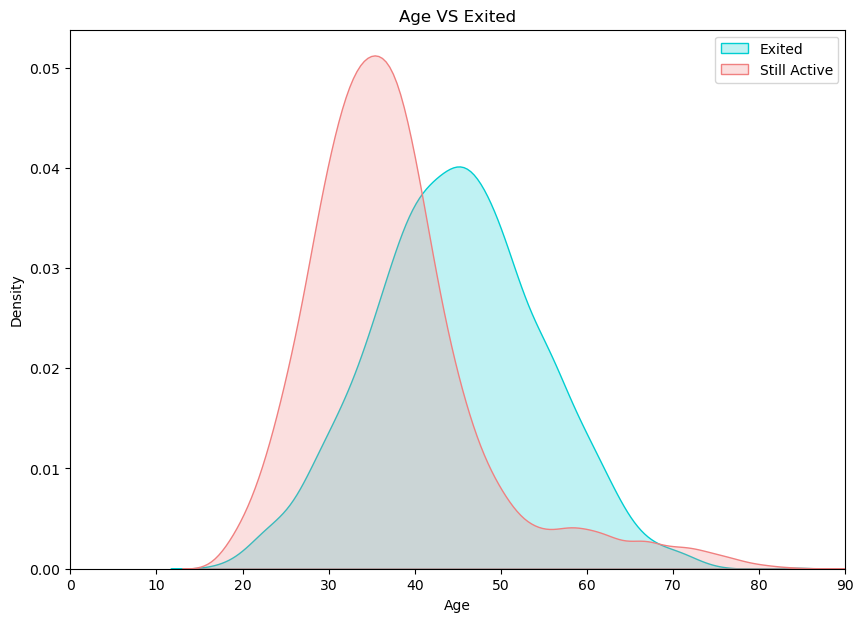

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

age_exited_1 = df6.filter(df6.Exited == 1).select("Age").toPandas()
age_exited_0 = df6.filter(df6.Exited == 0).select("Age").toPandas()

plt.figure(figsize=(10, 7))
sns.kdeplot(age_exited_1["Age"], color="darkturquoise", shade=True, label='Exited')
sns.kdeplot(age_exited_0["Age"], color="lightcoral", shade=True, label='Still Active')

plt.title('Age VS Exited')
plt.xlabel('Age')
plt.xlim(0, 90)
plt.legend()
plt.show()

### conclusion


#### 1- Risk of Churn (Exit) is higher among customers in their 40s and early 50s. This age group seems to show the most dissatisfaction or    higher exit rate.
#### 2- Younger customers are more likely to stay with the service, with a relatively lower churn rate.
#### 3- For older customers, after 50, the likelihood of exiting decreases, but the number of older customers overall might also be smaller.

In [17]:
from pyspark.sql.functions import col, when

# Assuming df4 is your DataFrame with the 'Age' column
df7 = df6.withColumn('Agecategory', when((col('Age') >= 45) & (col('Age') <= 50), 1).otherwise(0))

# Show the result
df7.show(10)

+---------+----------+----------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------+---------+----------------+---------------+-----------------+-----------+
|RowNumber|CustomerId|         Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|IS_Male|IS_Female|Geography_France|Geography_Spain|Geography_Germany|Agecategory|
+---------+----------+----------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------+---------+----------------+---------------+-----------------+-----------+
|      130|  15591607|          Fernie|        770|   France|  Male| 24|     9|101827.07|            1|        1|             0|      167256.35|     0|      1|        0|               1|              0|                0|          0|
|      360|  15592386|        Campbell|        520|   France|  Male|

In [32]:
df1.agg(f.max("CreditScore")).collect()[0][0]

850

/tmp/ipykernel_7794/2294174381.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_exited_1["CreditScore"], color="darkturquoise", shade=True, label='Exited')
/tmp/ipykernel_7794/2294174381.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_exited_0["CreditScore"], color="lightcoral", shade=True, label='Still Active')


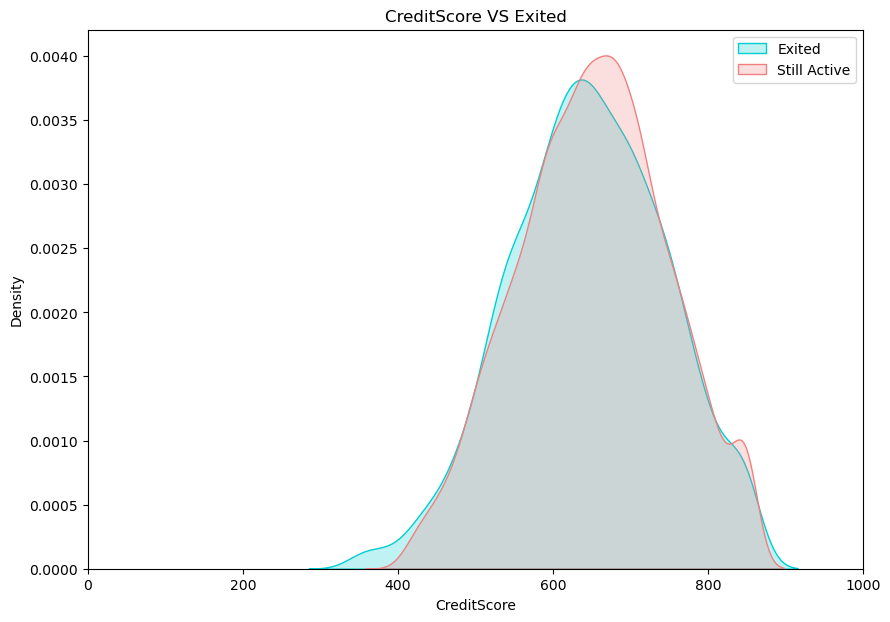

In [37]:
credit_exited_1 = df7.filter(df7.Exited == 1).select("CreditScore").toPandas()
credit_exited_0 = df7.filter(df7.Exited == 0).select("CreditScore").toPandas()

plt.figure(figsize=(10, 7))
sns.kdeplot(credit_exited_1["CreditScore"], color="darkturquoise", shade=True, label='Exited')
sns.kdeplot(credit_exited_0["CreditScore"], color="lightcoral", shade=True, label='Still Active')

plt.title('CreditScore VS Exited')
plt.xlabel('CreditScore')
plt.xlim(0, 1000)
plt.legend()
plt.show()

#### 8- Features Selection

In [18]:
df8 = df7.drop('RowNumber')\
         .drop('CustomerId')\
         .drop('Surname')\
         .drop('Geography')\
         .drop('Gender')\
         

In [19]:
df8.columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'IS_Male',
 'IS_Female',
 'Geography_France',
 'Geography_Spain',
 'Geography_Germany',
 'Agecategory']

In [20]:
df8.show()

+-----------+---+------+---------+-------------+---------+--------------+---------------+------+-------+---------+----------------+---------------+-----------------+-----------+
|CreditScore|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|IS_Male|IS_Female|Geography_France|Geography_Spain|Geography_Germany|Agecategory|
+-----------+---+------+---------+-------------+---------+--------------+---------------+------+-------+---------+----------------+---------------+-----------------+-----------+
|        770| 24|     9|101827.07|            1|        1|             0|      167256.35|     0|      1|        0|               1|              0|                0|          0|
|        520| 58|     3|      0.0|            2|        0|             1|       32790.02|     0|      1|        0|               1|              0|                0|          0|
|        672| 56|     2|209767.31|            2|        1|             1|      150694.42|     1|      0|      

In [85]:
df1.groupBy("Exited").count().show()


+------+-----+
|Exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+



In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

# Handle imbalance: Perform undersampling


In [23]:
def undersample(df, target_col):
    # Count each class
    exited_count = df.groupBy(target_col).count().collect()
    class_1_count = exited_count[0][1] if exited_count[0][0] == 1 else exited_count[1][1]
    class_0_count = exited_count[0][1] if exited_count[0][0] == 0 else exited_count[1][1]

    # Calculate ratio of class 1 and class 0
    sampling_ratio = class_1_count / class_0_count

    # Perform undersampling on class 0
    class_0_df = df.filter(F.col(target_col) == 0).sample(sampling_ratio, seed=42)
    class_1_df = df.filter(F.col(target_col) == 1)

    # Combine the two classes back
    return class_0_df.union(class_1_df)

In [24]:
# Load your processed data (assuming it's already preprocessed)
# df is your DataFrame with all the features ready for training

# Handle imbalance by undersampling the majority class
df_balanced = undersample(df8, "Exited")


In [25]:
# Define the features and label
feature_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'IS_Male', 'IS_Female', 'Geography_France', 'Geography_Spain', 'Geography_Germany']
target_column = 'Exited'

# StringIndexer for categorical columns (optional, as you already have encoded columns)
# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")



In [26]:
# Logistic Regression Model
lr = LogisticRegression(labelCol=target_column, featuresCol="features", maxIter=10)


In [27]:
# Define the pipeline
pipeline = Pipeline(stages=[assembler, lr])


In [28]:

# Split the data into training and testing sets
train_df, test_df = df_balanced.randomSplit([0.8, 0.2], seed=42)


In [29]:
# Train the model
model = pipeline.fit(train_df)


24/09/25 18:50:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [30]:

# Predict on the training data and calculate accuracy
train_predictions = model.transform(train_df)
train_accuracy = train_predictions.filter(train_predictions[target_column] == train_predictions.prediction).count() / float(train_df.count())


24/09/25 18:50:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [31]:
# Predict on the test data
test_df = test_df.drop(target_column)  # Drop target column for the test set


In [36]:



test_predictions = model.transform(test_df)

# Add "PredictedExited" column with integer type
test_predictions = test_predictions.withColumn("PredictedExited", F.col("prediction").cast("int"))

# Calculate accuracy on the test data by comparing the actual and predicted values
test_correct = test_predictions.filter(F.col("Exited") == F.col("PredictedExited")).count()
test_total = test_predictions.count()
test_accuracy = test_correct / float(test_total)

# Print the results
print(f"Training Accuracy (AUC): {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Training Accuracy (AUC): 0.707605800532702
Test Accuracy: 0.7168597168597168


In [45]:
test_predictions_clean = test_predictions.drop("features", "rawPrediction", "probability", "prediction")

# Check if the columns were actually dropped
test_predictions_clean.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- IS_Male: integer (nullable = false)
 |-- IS_Female: integer (nullable = false)
 |-- Geography_France: integer (nullable = false)
 |-- Geography_Spain: integer (nullable = false)
 |-- Geography_Germany: integer (nullable = false)
 |-- Agecategory: integer (nullable = false)
 |-- PredictedExited: integer (nullable = true)



In [46]:
test_predictions_clean.show(truncate=False)

+-----------+---+------+---------+-------------+---------+--------------+---------------+-------+---------+----------------+---------------+-----------------+-----------+---------------+
|CreditScore|Age|Tenure|Balance  |NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|IS_Male|IS_Female|Geography_France|Geography_Spain|Geography_Germany|Agecategory|PredictedExited|
+-----------+---+------+---------+-------------+---------+--------------+---------------+-------+---------+----------------+---------------+-----------------+-----------+---------------+
|411        |54 |9     |0.0      |1            |0        |1             |76621.49       |0      |1        |1               |0              |0                |0          |1              |
|422        |33 |2     |0.0      |2            |1        |0             |102655.31      |0      |1        |1               |0              |0                |0          |0              |
|426        |34 |9     |0.0      |2            |1        |0      

In [47]:
output_path = "/home/wick/fina_project/churn_data.csv"
test_predictions_clean.coalesce(1).write.mode("append").option("header", "true").csv(output_path)